In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('logistic_regression_adv').getOrCreate()
from pyspark.ml.classification import LogisticRegression
df = spark.read.csv('survey.csv',header=True,inferSchema=True)
df.printSchema()
print(df.columns)

root
 |-- Timestamp: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- state: string (nullable = true)
 |-- self_employed: string (nullable = true)
 |-- family_history: string (nullable = true)
 |-- treatment: string (nullable = true)
 |-- work_interfere: string (nullable = true)
 |-- no_employees: string (nullable = true)
 |-- remote_work: string (nullable = true)
 |-- tech_company: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- care_options: string (nullable = true)
 |-- wellness_program: string (nullable = true)
 |-- seek_help: string (nullable = true)
 |-- anonymity: string (nullable = true)
 |-- leave: string (nullable = true)
 |-- mental_health_consequence: string (nullable = true)
 |-- phys_health_consequence: string (nullable = true)
 |-- coworkers: string (nullable = true)
 |-- supervisor: string (nullable = true)
 |-- mental_health_interview: string (nullable = tru

In [2]:
df.show()

+---------------+---+------+--------------+-----+-------------+--------------+---------+--------------+--------------+-----------+------------+----------+------------+----------------+----------+----------+------------------+-------------------------+-----------------------+------------+------------+-----------------------+---------------------+------------------+---------------+--------------------+
|      Timestamp|Age|Gender|       Country|state|self_employed|family_history|treatment|work_interfere|  no_employees|remote_work|tech_company|  benefits|care_options|wellness_program| seek_help| anonymity|             leave|mental_health_consequence|phys_health_consequence|   coworkers|  supervisor|mental_health_interview|phys_health_interview|mental_vs_physical|obs_consequence|            comments|
+---------------+---+------+--------------+-----+-------------+--------------+---------+--------------+--------------+-----------+------------+----------+------------+----------------+--------

In [3]:
df.crosstab('treatment', 'family_history').show()

+------------------------+---+---+
|treatment_family_history| No|Yes|
+------------------------+---+---+
|                      No|495|127|
|                     Yes|272|365|
+------------------------+---+---+



In [4]:
df.crosstab('treatment', 'self_employed').show()

+-----------------------+---+---+---+
|treatment_self_employed| NA| No|Yes|
+-----------------------+---+---+---+
|                     No|  9|545| 68|
|                    Yes|  9|550| 78|
+-----------------------+---+---+---+



In [5]:
df.crosstab('treatment', 'work_interfere').show()

+------------------------+---+-----+-----+------+---------+
|treatment_work_interfere| NA|Never|Often|Rarely|Sometimes|
+------------------------+---+-----+-----+------+---------+
|                      No|260|  183|   21|    51|      107|
|                     Yes|  4|   30|  123|   122|      358|
+------------------------+---+-----+-----+------+---------+



In [6]:
df.describe("Age").show()

+-------+--------------------+
|summary|                 Age|
+-------+--------------------+
|  count|                1259|
|   mean| 7.942814831135821E7|
| stddev|2.8182994429819684E9|
|    min|               -1726|
|    max|         99999999999|
+-------+--------------------+



In [7]:
df.groupBy('no_employees').mean().show()

+--------------+-------------------+
|  no_employees|           avg(Age)|
+--------------+-------------------+
|       100-500|  32.01704545454545|
|       6��25��| 31.717241379310344|
|        1��5��|6.172839826728395E8|
|      500-1000|  34.06666666666667|
|More than 1000|  33.49290780141844|
|        26-100|  24.94463667820069|
+--------------+-------------------+



In [8]:
df.describe().show()

+-------+---------------+--------------------+------------------+---------+-----+-------------+--------------+---------+--------------+--------------+-----------+------------+----------+------------+----------------+----------+----------+----------+-------------------------+-----------------------+---------+----------+-----------------------+---------------------+------------------+---------------+--------------------+
|summary|      Timestamp|                 Age|            Gender|  Country|state|self_employed|family_history|treatment|work_interfere|  no_employees|remote_work|tech_company|  benefits|care_options|wellness_program| seek_help| anonymity|     leave|mental_health_consequence|phys_health_consequence|coworkers|supervisor|mental_health_interview|phys_health_interview|mental_vs_physical|obs_consequence|            comments|
+-------+---------------+--------------------+------------------+---------+-----+-------------+--------------+---------+--------------+--------------+----

In [9]:
df = df.select('Age', 'Gender', 'self_employed', 'family_history', 'treatment', 'work_interfere','no_employees', 'benefits', 'care_options', 'seek_help')
df.printSchema()

root
 |-- Age: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- self_employed: string (nullable = true)
 |-- family_history: string (nullable = true)
 |-- treatment: string (nullable = true)
 |-- work_interfere: string (nullable = true)
 |-- no_employees: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- care_options: string (nullable = true)
 |-- seek_help: string (nullable = true)



In [10]:
replace_df = df.na.replace(["cis female", "f","Female", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"],"female","Gender").replace(["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ","Male","M", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"],"male","Gender").replace(["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"],"trans","Gender").show()

+---+------+-------------+--------------+---------+--------------+--------------+----------+------------+----------+
|Age|Gender|self_employed|family_history|treatment|work_interfere|  no_employees|  benefits|care_options| seek_help|
+---+------+-------------+--------------+---------+--------------+--------------+----------+------------+----------+
| 37|female|           NA|            No|      Yes|         Often|       6��25��|       Yes|    Not sure|       Yes|
| 44|  male|           NA|            No|       No|        Rarely|More than 1000|Don't know|          No|Don't know|
| 32|  male|           NA|            No|       No|        Rarely|       6��25��|        No|          No|        No|
| 31|  male|           NA|           Yes|      Yes|         Often|        26-100|        No|         Yes|        No|
| 31|  male|           NA|            No|       No|         Never|       100-500|       Yes|          No|Don't know|
| 33|  male|           NA|           Yes|       No|     Sometime

In [11]:
import pandas as pd
pd.DataFrame(df.take(10), columns=df.columns)

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,benefits,care_options,seek_help
0,37,Female,NA,No,Yes,Often,6��25��,Yes,Not sure,Yes
1,44,M,NA,No,No,Rarely,More than 1000,Don't know,No,Don't know
2,32,Male,NA,No,No,Rarely,6��25��,No,No,No
3,31,Male,NA,Yes,Yes,Often,26-100,No,Yes,No
4,31,Male,NA,No,No,Never,100-500,Yes,No,Don't know
5,33,Male,NA,Yes,No,Sometimes,6��25��,Yes,Not sure,Don't know
6,35,Female,NA,Yes,Yes,Sometimes,1��5��,No,No,No
7,39,M,NA,No,No,Never,1��5��,No,Yes,No
8,42,Female,NA,Yes,Yes,Sometimes,100-500,Yes,Yes,No
9,23,Male,NA,No,No,Never,26-100,Don't know,No,Don't know


In [12]:
df = df.na.drop()
df.show()
print("Total data points:", df.count())

+---+------+-------------+--------------+---------+--------------+--------------+----------+------------+----------+
|Age|Gender|self_employed|family_history|treatment|work_interfere|  no_employees|  benefits|care_options| seek_help|
+---+------+-------------+--------------+---------+--------------+--------------+----------+------------+----------+
| 37|Female|           NA|            No|      Yes|         Often|       6��25��|       Yes|    Not sure|       Yes|
| 44|     M|           NA|            No|       No|        Rarely|More than 1000|Don't know|          No|Don't know|
| 32|  Male|           NA|            No|       No|        Rarely|       6��25��|        No|          No|        No|
| 31|  Male|           NA|           Yes|      Yes|         Often|        26-100|        No|         Yes|        No|
| 31|  Male|           NA|            No|       No|         Never|       100-500|       Yes|          No|Don't know|
| 33|  Male|           NA|           Yes|       No|     Sometime

In [13]:
df = df.na.drop(subset="treatment")
df.show()
print("Total data points:", df.count())

+---+------+-------------+--------------+---------+--------------+--------------+----------+------------+----------+
|Age|Gender|self_employed|family_history|treatment|work_interfere|  no_employees|  benefits|care_options| seek_help|
+---+------+-------------+--------------+---------+--------------+--------------+----------+------------+----------+
| 37|Female|           NA|            No|      Yes|         Often|       6��25��|       Yes|    Not sure|       Yes|
| 44|     M|           NA|            No|       No|        Rarely|More than 1000|Don't know|          No|Don't know|
| 32|  Male|           NA|            No|       No|        Rarely|       6��25��|        No|          No|        No|
| 31|  Male|           NA|           Yes|      Yes|         Often|        26-100|        No|         Yes|        No|
| 31|  Male|           NA|            No|       No|         Never|       100-500|       Yes|          No|Don't know|
| 33|  Male|           NA|           Yes|       No|     Sometime

In [14]:
df = df[df.self_employed != 'NA']
df.show(5)
print("Total data points:", df.count())

+---+------+-------------+--------------+---------+--------------+------------+--------+------------+----------+
|Age|Gender|self_employed|family_history|treatment|work_interfere|no_employees|benefits|care_options| seek_help|
+---+------+-------------+--------------+---------+--------------+------------+--------+------------+----------+
| 46|  male|          Yes|           Yes|       No|     Sometimes|      1��5��|     Yes|    Not sure|Don't know|
| 36|  Male|          Yes|           Yes|       No|            NA|     6��25��|      No|          No|        No|
| 29|  Male|           No|           Yes|      Yes|     Sometimes|     100-500|     Yes|         Yes|        No|
| 31|  male|          Yes|            No|       No|         Never|      1��5��|      No|          No|        No|
| 46|  Male|           No|            No|      Yes|         Often|      26-100|     Yes|         Yes|        No|
+---+------+-------------+--------------+---------+--------------+------------+--------+--------

In [15]:
df = df[(df.Age < 100) & (df.Age >1)]
df.show(5)
print("Total data points:", df.count())

+---+------+-------------+--------------+---------+--------------+------------+--------+------------+----------+
|Age|Gender|self_employed|family_history|treatment|work_interfere|no_employees|benefits|care_options| seek_help|
+---+------+-------------+--------------+---------+--------------+------------+--------+------------+----------+
| 46|  male|          Yes|           Yes|       No|     Sometimes|      1��5��|     Yes|    Not sure|Don't know|
| 36|  Male|          Yes|           Yes|       No|            NA|     6��25��|      No|          No|        No|
| 29|  Male|           No|           Yes|      Yes|     Sometimes|     100-500|     Yes|         Yes|        No|
| 31|  male|          Yes|            No|       No|         Never|      1��5��|      No|          No|        No|
| 46|  Male|           No|            No|      Yes|         Often|      26-100|     Yes|         Yes|        No|
+---+------+-------------+--------------+---------+--------------+------------+--------+--------

In [16]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)

In [17]:
Gender_indexer = StringIndexer(inputCol='Gender',outputCol='GenderIndex')
self_employed_indexer = StringIndexer(inputCol='self_employed',outputCol='self_employedIndex')
family_history_indexer = StringIndexer(inputCol='family_history',outputCol='family_historyIndex')
work_interfere_indexer = StringIndexer(inputCol='work_interfere',outputCol='work_interfereIndex')
no_employees_indexer = StringIndexer(inputCol='no_employees',outputCol='no_employeesIndex')
benefits_indexer = StringIndexer(inputCol='benefits',outputCol='benefitsIndex')
care_options_indexer = StringIndexer(inputCol='care_options',outputCol='care_optionsIndex')
seek_help_indexer = StringIndexer(inputCol='seek_help',outputCol='seek_helpIndex')
treatment_indexer = StringIndexer(inputCol='treatment',outputCol='label')

In [18]:
Gender_encoder = OneHotEncoder(inputCol='GenderIndex',outputCol='GenderVec')
self_employed_encoder = OneHotEncoder(inputCol='self_employedIndex',outputCol='self_employedVec')
family_history_encoder = OneHotEncoder(inputCol='family_historyIndex',outputCol='family_historyVec')
work_interfere_encoder = OneHotEncoder(inputCol='work_interfereIndex',outputCol='work_interfereVec')
no_employees_encoder = OneHotEncoder(inputCol='no_employeesIndex',outputCol='no_employeesVec')
benefits_encoder = OneHotEncoder(inputCol='benefitsIndex',outputCol='benefitsVec')
care_options_encoder = OneHotEncoder(inputCol='care_optionsIndex',outputCol='care_optionsVec')
seek_help_encoder = OneHotEncoder(inputCol='seek_helpIndex',outputCol='seek_helpVec')

In [19]:
assembler = VectorAssembler(inputCols=['GenderVec','self_employedVec','family_historyVec','work_interfereVec',
                                       'no_employeesVec','benefitsVec','care_optionsVec','seek_helpVec',
                                       'Age'], outputCol="features")

In [20]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[Gender_indexer, self_employed_indexer, family_history_indexer, treatment_indexer,
                            work_interfere_indexer, no_employees_indexer, benefits_indexer, care_options_indexer, seek_help_indexer,
                            Gender_encoder, self_employed_encoder, family_history_encoder,no_employees_encoder, 
                            work_interfere_encoder, benefits_encoder, care_options_encoder,
                            seek_help_encoder, assembler])
pipeline_model = pipeline.fit(df)
pipe_df = pipeline_model.transform(df)
pipe_df = pipe_df.select('label', 'features')

In [21]:
from pyspark.ml.classification import LogisticRegression
train_data, test_data = pipe_df.randomSplit([0.7,0.3])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))
lr_model = LogisticRegression(featuresCol='features',labelCol='label')
lr_model = lr_model.fit(train_data)
results = lr_model.transform(test_data)

Training Dataset Count: 865
Test Dataset Count: 371


In [22]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lr_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

<Figure size 640x480 with 1 Axes>

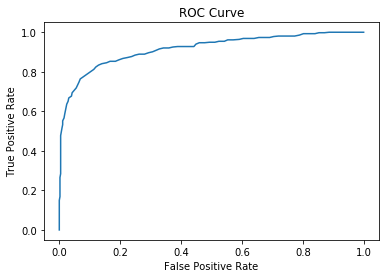

Area Under the Curve: 0.915938420348059


In [23]:
training_summary = lr_model.summary
ROC = training_summary.roc.toPandas()
plt.plot(ROC['FPR'],ROC['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))

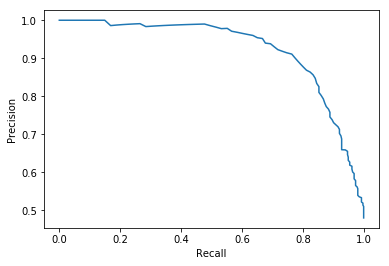

In [24]:
pr = training_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [38]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train_data)
predictions = dtModel.transform(test_data)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7512836221483167


In [42]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
rfModel.featureImportance
df.take(1)

Test Area Under ROC: 0.8729068207013246


[Row(Age=46, Gender='male', self_employed='Yes', family_history='Yes', treatment='No', work_interfere='Sometimes', no_employees='1��5��', benefits='Yes', care_options='Not sure', seek_help="Don't know")]

In [48]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbtModel = gbt.fit(train_data)
predictions = gbtModel.transform(test_data)
predictions.select("prediction", "label", "features").show(5)
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|(64,[0,46,47,48,5...|
|       0.0|  0.0|(64,[0,46,47,48,5...|
|       0.0|  0.0|(64,[0,46,47,48,5...|
|       0.0|  0.0|(64,[0,46,47,48,5...|
|       0.0|  0.0|(64,[0,46,47,48,5...|
+----------+-----+--------------------+
only showing top 5 rows

Test Accuracy = 0.824798


In [49]:
gbtModel.featureImportances

SparseVector(64, {0: 0.0172, 1: 0.026, 2: 0.0122, 3: 0.045, 4: 0.0291, 5: 0.0066, 7: 0.0104, 33: 0.0102, 36: 0.0054, 38: 0.028, 40: 0.0051, 46: 0.0113, 47: 0.0171, 48: 0.0293, 49: 0.2233, 50: 0.0958, 51: 0.018, 52: 0.0, 53: 0.0296, 54: 0.0119, 55: 0.0352, 56: 0.0212, 57: 0.0644, 58: 0.0291, 59: 0.0244, 60: 0.017, 61: 0.0035, 62: 0.0133, 63: 0.1601})

In [50]:
df.take(1)

[Row(Age=46, Gender='male', self_employed='Yes', family_history='Yes', treatment='No', work_interfere='Sometimes', no_employees='1��5��', benefits='Yes', care_options='Not sure', seek_help="Don't know")]

In [35]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
dt_model.featureImportances

Root Mean Squared Error (RMSE) on test data = 0.364958


SparseVector(64, {0: 0.0021, 1: 0.0002, 5: 0.0064, 46: 0.0006, 47: 0.0423, 49: 0.4573, 50: 0.38, 51: 0.0188, 53: 0.0067, 55: 0.0038, 57: 0.0128, 60: 0.0394, 63: 0.0295})

In [36]:
df.take(1)

[Row(Age=46, Gender='male', self_employed='Yes', family_history='Yes', treatment='No', work_interfere='Sometimes', no_employees='1��5��', benefits='Yes', care_options='Not sure', seek_help="Don't know")]

In [52]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label', maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'label', 'features').show(5)
gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
|0.04691696823110311|  0.0|(64,[0,46,47,48,5...|
|0.33355650678491555|  0.0|(64,[0,46,47,48,5...|
|0.08951839161257537|  0.0|(64,[0,46,47,48,5...|
|0.08863973071300596|  0.0|(64,[0,46,47,48,5...|
|0.35111764031650966|  0.0|(64,[0,46,47,48,5...|
+-------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.365097


In [54]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_predictions.select('prediction', 'label', 'features').show(5)
rf_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
|0.14396531972279966|  0.0|(64,[0,46,47,48,5...|
| 0.2052253720671259|  0.0|(64,[0,46,47,48,5...|
|0.14189345140696136|  0.0|(64,[0,46,47,48,5...|
|0.15410619875950457|  0.0|(64,[0,46,47,48,5...|
|0.32988700744317356|  0.0|(64,[0,46,47,48,5...|
+-------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.356752
